# <center> <u> Vasicek Model </u> </center>

In [1]:
import numpy as np
import pandas as pd 

from numba import jit, prange

import seaborn as sns
import matplotlib.pyplot as plt 

## <center> Set Seaborn Theme </center>

In [2]:
sns.set_theme(
    style = "darkgrid",
    palette = "bright",
)

plt.rc('figure', figsize = (10, 5))

## <center> Estimate Parameters of Vasicek Model </center> 

## <center> $ dr = a(b - r) \cdot dt + \sigma dz $ </center> 

## <center> $ r_{t+1} = r_{t} + \lambda(\mu - r_{t})dt + \sigma \epsilon \sqrt{dt} $ </center>

In [3]:
df = pd.read_excel("Data/VasicekCIR.xls", sheet_name = "Data (See Section 31.4)", skipfooter = 1)

In [4]:
df.head()

,Date,3 mnth rate(%),Rate (decimal),Change
0,1982-01-04,11.87,0.1187,0.0033
1,1982-01-05,12.20,0.1220,-0.0004
2,1982-01-06,12.16,0.1216,0.0001
3,1982-01-07,12.17,0.1217,-0.0019
4,1982-01-08,11.98,0.1198,0.0051


In [5]:
df.tail()

,Date,3 mnth rate(%),Rate (decimal),Change
8658,2016-08-16,0.27,0.0027,0.0003
8659,2016-08-17,0.30,0.0030,0.0000
8660,2016-08-18,0.30,0.0030,0.0000
8661,2016-08-19,0.30,0.0030,-0.0001
8662,2016-08-22,0.29,0.0029,0.0001


In [6]:
df = df[df["Rate (decimal)"] > 0.01]

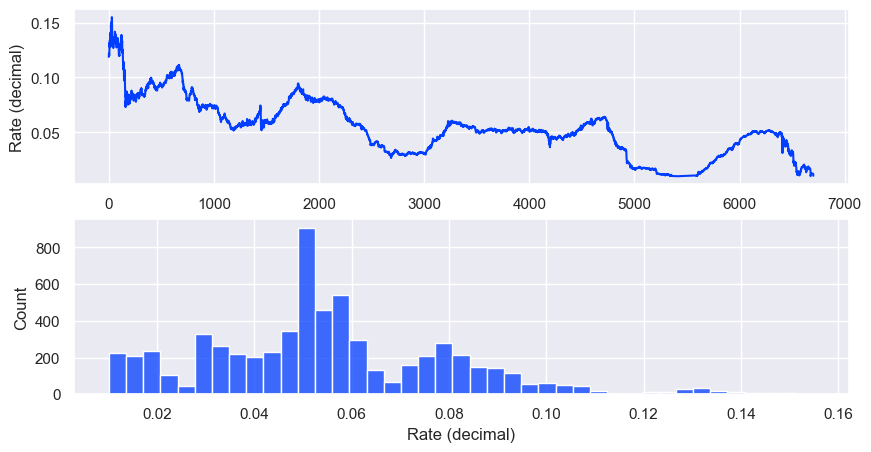

In [7]:
fig, axes = plt.subplots(2, 1)

sns.lineplot(
    df["Rate (decimal)"],
    ax = axes[0]
)

sns.histplot(
    df["Rate (decimal)"],
    ax = axes[1]
)

plt.show()

## <center> Optimize with Maximum Likelihood Estimation </center> 

## <center> $ f(x) = \frac{1}{\sqrt{2 \pi \sigma^{2}}} e^{-\frac{1}{2} (\frac{x - \mu}{\sigma})^{2}} $ </center> 

## <center> $ f(r_{t+1} | r_{t}, \mu, \lambda, \sigma) = \frac{1}{\sqrt{2 \pi \sigma^{2} dt}} e^{\frac{-(r_{t+1} - (r_{t} + \lambda (\mu - r_{t}) dt))^{2}}{2 \sigma^{2} dt}}$ </center>

## <center> Log Likelihood Function </center> 

## <center> $ \ell = \prod_{i=1}^{N} f(r_{t+1} | r_{t}, \mu, \lambda, \sigma) = \sum_{i=1}^{N} f(r_{t+1} | r_{t}, \mu, \lambda, \sigma) $ </center>

## <center> $ \ell = \frac{-N}{2} ln(2 \pi \sigma^{2} dt) - \sum_{i=1}^{N} \frac{[r_{t+1} - (r_{t} + \lambda (\mu - r_{t}) dt)]^{2}}{2 \sigma^{2} dt}$ </center> 

In [8]:
N = 1000
dt = 1/252
rates = df["Rate (decimal)"].to_numpy()

In [9]:
@jit(nopython = True, parallel = True)
def vasicek_log_likelihood(r, mu, l, sigma, dt):
    """
    Computes the Log Likelihood Function of the Vasicek Model 
    """
    
    N = len(rates)
    summ = 0
    
    for i in prange(N - 1):
        summ += (r[i+1] - (r[i] + l * (mu - r[i]) * dt))**2 / (2 * sigma * dt) 
    
    return (-N / 2) * np.log(2 * np.pi * sigma * dt) - summ

In [10]:
mu = np.linspace(-1, 1, N)
l = 0.15
sigma = 0.20

func = np.copy(mu)
for i, x in enumerate(mu): 
    func[i] = vasicek_log_likelihood(rates, x, l, sigma, dt)

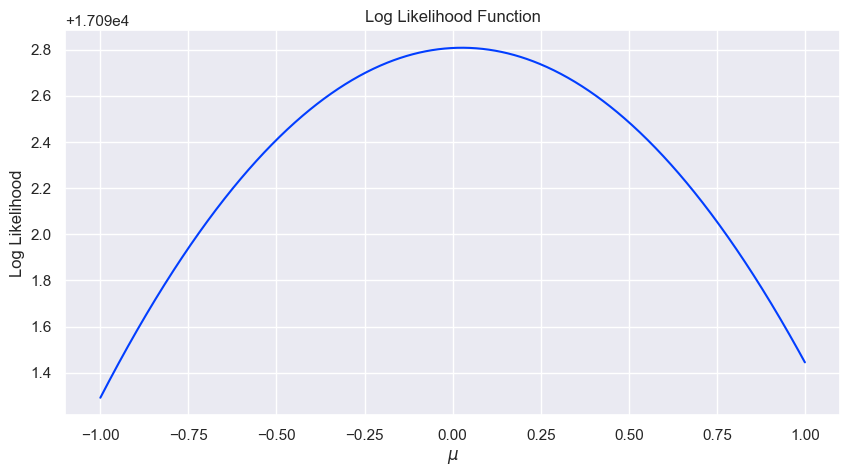

In [11]:
ax = sns.lineplot(
    x = mu,
    y = func, 
)

ax.set(
    title = "Log Likelihood Function",
    xlabel = "$ \mu $",
    ylabel = "Log Likelihood",
)

plt.show()

In [12]:
mu = 0
l = np.linspace(-1, 1, N)
sigma = 0.20

func = np.copy(l)
for i, x in enumerate(l): 
    func[i] = vasicek_log_likelihood(rates, mu, x, sigma, dt)

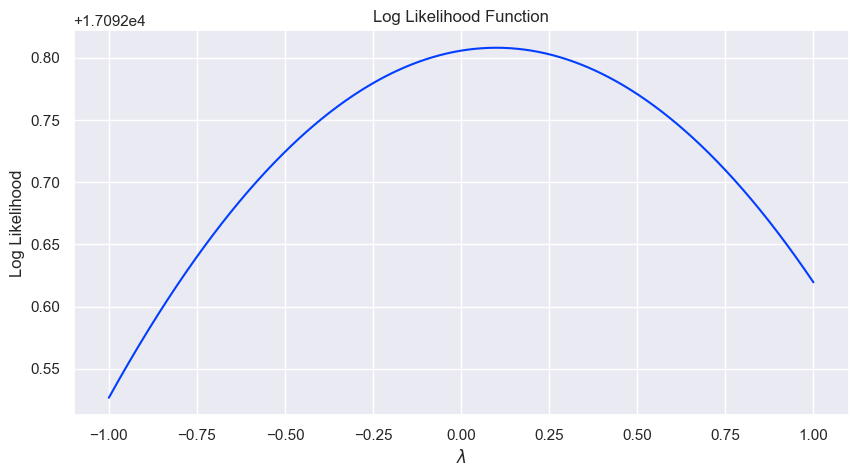

In [13]:
ax = sns.lineplot(
    x = l,
    y = func, 
)

ax.set(
    title = "Log Likelihood Function",
    xlabel = "$ \lambda $",
    ylabel = "Log Likelihood",
)

plt.show()

In [33]:
mu = 0
l = 0.125
sigma = np.linspace(0.05, 0.50, N)

func = np.copy(sigma)
for i, x in enumerate(sigma): 
    func[i] = vasicek_log_likelihood(rates, mu, l, x, dt)

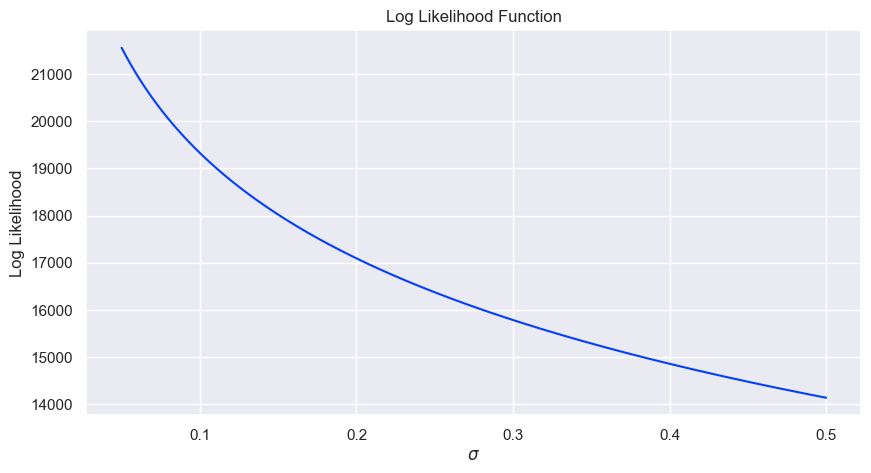

In [34]:
ax = sns.lineplot(
    x = sigma,
    y = func, 
)

ax.set(
    title = "Log Likelihood Function",
    xlabel = "$ \sigma $",
    ylabel = "Log Likelihood",
)

plt.show()

## <center> Vasicek Parameter Estimates </center> 

## <center> $ \hat{\mu} = \frac{1}{N} \sum_{i=1}^{N} \frac{r_{i+1} - r_{i} (1 - \lambda dt)}{\lambda dt} $ </center>

In [16]:
@jit(nopython = True, parallel = True)
def vasicek_mu(r, l, dt):
    """
    
    """
    
    N = len(rates)
    summ = 0
    
    for i in prange(N - 1):
        summ += (r[i+1] - r[i] * (1 - l * dt)) / (l * dt)
    
    return summ / N

In [17]:
L = np.linspace(-1, 1, 100)
mu = np.copy(L)

for i, l in enumerate(L):
    mu[i] = vasicek_mu(rates, l, dt)

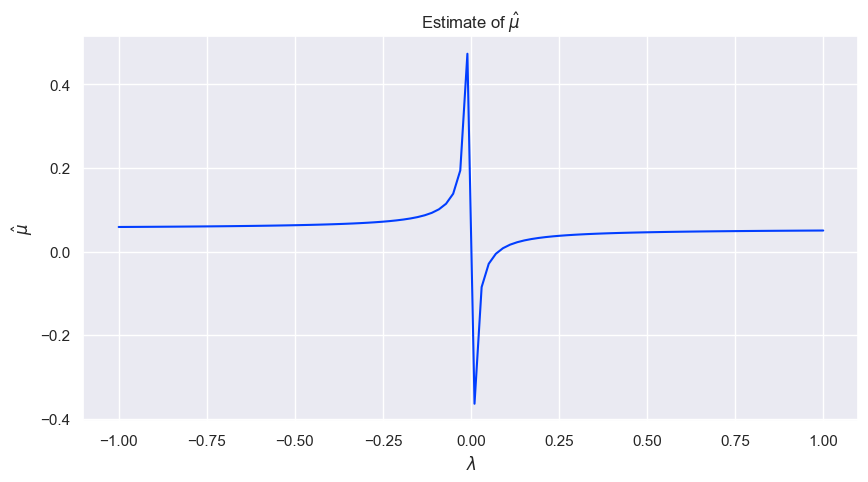

In [18]:
ax = sns.lineplot(
    x = L,
    y = mu,
)

ax.set(
    title= "Estimate of $\hat{\mu}$",
    xlabel = "$ \lambda $",
    ylabel = "$ \hat{\mu} $",
)

plt.show()

In [19]:
@jit(nopython = True, parallel = True)
def vasicek_lambda(r, mu, dt):
    """
    
    """
    
    N = len(r)
    summ1 = 0 
    summ2 = 0
    
    for i in prange(N - 1):
        summ1 += (r[i+1] - r[i]) * (mu - r[i])
        summ2 += (mu - r[i])**2
    
    return (summ1 / summ2) * (1 / dt)

In [20]:
mu = np.linspace(-1, 1, 100)

lam = np.copy(mu)
for i, m in enumerate(mu):
    lam[i] = vasicek_lambda(rates, m, dt)

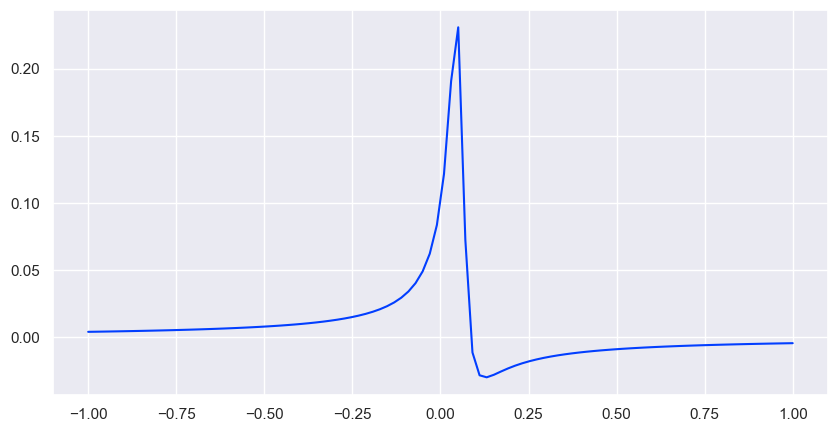

In [21]:
ax = sns.lineplot(
    x = mu,
    y = lam,
)

plt.show()

In [22]:
@jit(nopython = True, parallel = True)
def vasicek_sigma(r, mu, l, dt):
    """
    
    """
    
    N = len(r)
    summ = 0
    
    for i in prange(N - 1):
        summ += (r[i+1] - (r[i] + l * (mu - r[i]) * dt))**2 / dt
    
    return summ / N

In [23]:
mu = np.linspace(-1, 1, 100)

vol = np.copy(mu)
for i, m in enumerate(mu):
    vol[i] = vasicek_sigma(rates, m, 0.15, dt)

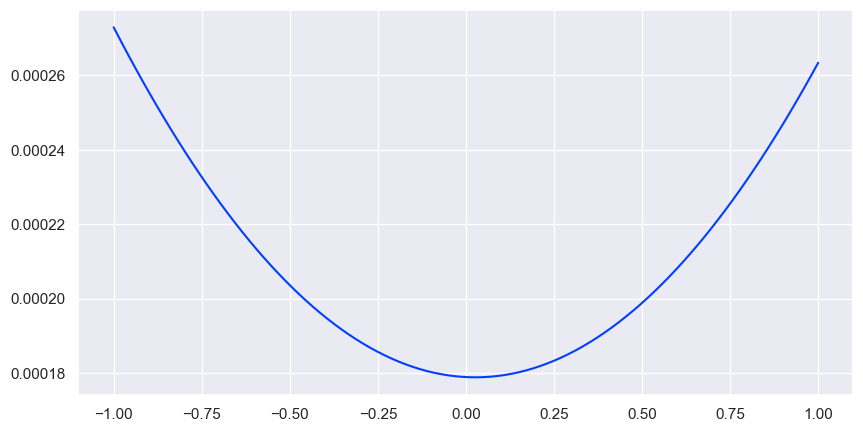

In [24]:
ax = sns.lineplot(
    x = mu,
    y = vol,
)

plt.show()